In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pandas as pd

from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

from scipy.linalg import lstsq
from scipy.optimize import curve_fit

import lightkurve as lk
import tessreduce as tr

import pickle

c:\Users\vishn\miniconda3\envs\SPT_Flares\lib\site-packages\lightkurve\config\__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to C:\Users\vishn\.lightkurve\cache. Please move all the files in the legacy directory C:\Users\vishn\.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


# Extracting Flares

## Pulling From SPT DATA

Grab databases of flare locations and times from SPT and TESS sector orbit times. 

In [2]:
spt_flares_df = pd.read_csv('spt3g_2019_2022_flare_star_catalog.csv')
spt_flares_df.sort_values(by= 'mjd')
spt_flares_df['sectors'] = [[] for _ in range(len(spt_flares_df))]
# print(spt_flares_df[['ra', 'dec']].head())

TESS_sectors_df = pd.read_csv("TESS_orbit_times.csv")
TESS_sectors_df = TESS_sectors_df.dropna(subset=['Start of Orbit'])
TESS_sectors_df = TESS_sectors_df.dropna(subset=['End of Orbit'])
TESS_sectors_df['Start of Orbit'] = TESS_sectors_df['Start of Orbit'].apply(lambda x: Time(x, format= 'iso'))
TESS_sectors_df['End of Orbit'] = TESS_sectors_df['End of Orbit'].apply(lambda x: Time(x, format= 'iso'))
print(spt_flares_df.columns)
print(TESS_sectors_df.columns)

Index(['spt_id', 'mjd', 'ts', 'ra', 'dec', '95_flux', '95_flux_err',
       '150_flux', '150_flux_err', '220_flux', '220_flux_err',
       'spectral_index_95_150', 'spectral_index_95_150_err',
       'spectral_index_150_220', 'spectral_index_150_220_err', 'dr3_source_id',
       'p-value', 'source_ra', 'source_dec', 'phot_g_mean_mag',
       'phot_bp_mean_mag', 'phot_rp_mean_mag', 'parallax', 'parallax_err',
       'binary', '2rxs_id', '2rxs_ref', '2rxs_flux', 'sectors'],
      dtype='object')
Index(['Sector', 'Orbit', 'Start of Orbit', 'End of Orbit'], dtype='object')


Identify time range of spt flare observations and use range to constrain TESS sectors to search

In [3]:
spt_t_bounds = (spt_flares_df.iloc[0]['mjd'], spt_flares_df.iloc[-1]['mjd'])
t_bounds = Time(spt_t_bounds, format= 'mjd')
t_bounds.format = 'iso'
print(t_bounds)
valid_sectors = TESS_sectors_df.loc[(TESS_sectors_df['Start of Orbit'] <= t_bounds[1]) & (TESS_sectors_df['End of Orbit'] >= t_bounds[0])]
# valid_sectors = set(valid_sectors['Sector'].apply(lambda x: f"TESS Sector {x}"))
valid_sectors = set(valid_sectors['Sector'].apply(lambda x: int(x)))
print(list(valid_sectors))

['2019-04-03 00:28:48.000' '2022-11-04 10:19:12.000']
[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]


Explicitly listing bounds time for TESS sectors in which SPT flares are coinciding. Done explcitityly as "TESS_orbit_times.csv" gives time ranges by orbit and would have to be combined by sector. For now, we only have 5 or so sectors to match though, so simple enough to do by hand

In [4]:
s13_start = Time({'year':2019, 'month':6, 'day':19}, format='ymdhms', scale='utc').unix
s13_end = Time({'year':2019, 'month':7, 'day':17}, format='ymdhms', scale='utc').unix
s27_start = Time({'year':2020, 'month':7, 'day':4}, format='ymdhms', scale='utc').unix
s27_end = Time({'year':2020, 'month':7, 'day':30}, format='ymdhms', scale='utc').unix
s28_start = s27_end
s28_end = Time({'year':2020, 'month':8, 'day':26}, format='ymdhms', scale='utc').unix
s29_start = s28_end
s29_end = Time({'year':2020, 'month':9, 'day':22}, format='ymdhms', scale='utc').unix
s30_start = s29_end
s30_end = Time({'year':2020, 'month':10, 'day':21}, format='ymdhms', scale='utc').unix
s31_start = s30_end
s31_end = Time({'year':2020, 'month':11, 'day':18}, format='ymdhms', scale='utc').unix


TESS_epoch_ranges = {13:(s13_start,s13_end),
                    27:(s27_start,s27_end),
                    28:(s28_start,s28_end),
                    29:(s29_start,s29_end),
                    30:(s30_start,s30_end),
                    31:(s31_start,s31_end)}

For each flare in spt_flare_catalog, identify possible TESS observations in relevant TESS sectors at flare skycoordinates using tesscut. Then further filter by explicit time ranges of sectors.

In [5]:
for i, flare in spt_flares_df.iterrows():
    ra = flare['ra']
    dec = flare['dec']
    flare_obs_start = Time(flare['mjd'],  format='mjd', scale='utc').unix
    c = SkyCoord(ra, dec, unit= 'deg')
    possible_matches = lk.search_tesscut(c, [sector for sector in valid_sectors])
    if len(possible_matches) >= 1:
        for data_prod in possible_matches:
            sector = int(data_prod.mission[0][11:])
            epoch_range = TESS_epoch_ranges[sector]
            if any(lower<flare_obs_start<upper for (lower,upper) in [epoch_range]):
                print(f'{i}/{spt_flares_df.shape[0]}: Match found for Sector {sector}')
                flare['sectors'] = flare['sectors'].append(sector)
            else:
                print(f'{i}/{spt_flares_df.shape[0]}: Sector {sector} - no overlap in time')
    else:
        print(f'{i}/{spt_flares_df.shape[0]}: no nearby targets')


0/111: Sector 28 - no overlap in time
0/111: Sector 29 - no overlap in time
1/111: Sector 30 - no overlap in time
1/111: Sector 28 - no overlap in time
1/111: Sector 29 - no overlap in time
2/111: Sector 30 - no overlap in time
2/111: Sector 29 - no overlap in time
3/111: Sector 29 - no overlap in time
4/111: Sector 27 - no overlap in time
5/111: Sector 29 - no overlap in time
6/111: Sector 29 - no overlap in time
7/111: Sector 28 - no overlap in time
8/111: Sector 27 - no overlap in time
9/111: Sector 27 - no overlap in time
10/111: Sector 27 - no overlap in time
11/111: Sector 30 - no overlap in time
11/111: Sector 29 - no overlap in time
12/111: Sector 28 - no overlap in time
13/111: Sector 28 - no overlap in time
13/111: Sector 29 - no overlap in time
14/111: Sector 30 - no overlap in time
14/111: Sector 29 - no overlap in time
15/111: Sector 28 - no overlap in time
15/111: Sector 29 - no overlap in time
16/111: Sector 30 - no overlap in time
16/111: Sector 29 - no overlap in time


In [6]:
spt_tess_candidates = spt_flares_df[spt_flares_df['sectors'].apply(lambda x: len(x) > 0)].reset_index()
spt_tess_candidates

,index,spt_id,mjd,ts,ra,dec,95_flux,95_flux_err,150_flux,150_flux_err,...,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,parallax,parallax_err,binary,2rxs_id,2rxs_ref,2rxs_flux,sectors
0,42,SPT-SV J232857.8-680230,59067.63,69.829680,352.241137,-68.041907,33.132387,6.050987,44.396645,6.479653,...,11.975413,13.298294,10.835975,21.814973,0.016096,True,2RXS J232857.7-680225,Freund,0.0,[28]
1,43,SPT-SV J220610.2-460354,59068.28,65.720511,331.542835,-46.065046,47.818806,8.045753,50.842904,8.377214,...,11.180600,11.394999,10.820612,2.686802,0.032307,False,NaN,NaN,NaN,[28]
2,46,SPT-SV J025532.4-570257,59110.27,1233.665708,43.885140,-57.049441,162.083004,7.148120,206.963060,7.665012,...,14.370894,16.325182,13.060138,21.889704,0.021013,False,NaN,NaN,NaN,[29]
3,49,SPT-SV J014432.2-460435,59131.78,48.975169,26.134435,-46.076393,45.598152,8.294850,36.632626,8.695313,...,15.635771,18.198709,14.208293,25.949235,0.045132,False,NaN,NaN,NaN,[30]


In [7]:
spt_tess_candidates[['spt_id', 'dr3_source_id']]

for i, flare in spt_tess_candidates.iterrows():
    ra = flare['ra']
    dec = flare['dec']
    c = SkyCoord(ra, dec, frame= 'icrs', unit= 'deg')
    print(i, c.to_string('hmsdms'))

0 23h28m57.87288s -68d02m30.8652s
1 22h06m10.2804s -46d03m54.1656s
2 02h55m32.4336s -57d02m57.9876s
3 01h44m32.2644s -46d04m35.0148s


In [8]:
spt_tess_candidates['TIC'] = spt_tess_candidates['spt_id']

spt_tess_candidates.at[0,'TIC'] = "TIC229807000"
spt_tess_candidates.at[1,'TIC'] = "TIC279255411" #TIC279255412
spt_tess_candidates.at[2,'TIC'] = "TIC207138379"
spt_tess_candidates.at[3,'TIC'] = "TIC401838575" 


spt_tess_candidates[['spt_id', 'dr3_source_id', 'TIC']]

,spt_id,dr3_source_id,TIC
0,SPT-SV J232857.8-680230,6388014157668558080,TIC229807000
1,SPT-SV J220610.2-460354,6567445491726233216,TIC279255411
2,SPT-SV J025532.4-570257,4727920241619206912,TIC207138379
3,SPT-SV J014432.2-460435,4954453580066220800,TIC401838575


### Getting SPT LCs

In [9]:
hdul = fits.open("spt3g_flare_lightcurves_flare_single_scan.fits")
hdul.info()
hdul[1].columns

Filename: spt3g_flare_lightcurves_flare_single_scan.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     42   111R x 12C   [30A, 30A, 30A, 30A, 30A, PD(18), PD(18), PD(18), PD(18), PD(18), PD(18), PD(18)]   


ColDefs(
    name = 'spt_id'; format = '30A'
    name = 'gaia_id'; format = '30A'
    name = 'ra'; format = '30A'; unit = 'deg'
    name = 'dec'; format = '30A'; unit = 'deg'
    name = 'mjd'; format = '30A'; unit = 'MJD'
    name = 'time'; format = 'PD(18)'; unit = 'MJD'
    name = '95_flux'; format = 'PD(18)'; unit = 'mJy'
    name = '150_flux'; format = 'PD(18)'; unit = 'mJy'
    name = '220_flux'; format = 'PD(18)'; unit = 'mJy'
    name = '95_err'; format = 'PD(18)'; unit = 'mJy'
    name = '150_err'; format = 'PD(18)'; unit = 'mJy'
    name = '220_err'; format = 'PD(18)'; unit = 'mJy'
)

In [10]:
spt_flare_data = hdul[1].data
spt_ids = spt_flare_data.spt_id.astype(str)
spt_ids = spt_ids.split('" "')
spt_ids = np.array(list(map(lambda x: x[0], spt_ids)))
lc_idxs = list()
for i in range(len(spt_tess_candidates)):
    lc_idxs.append(np.where(spt_ids == spt_tess_candidates.at[i,'spt_id'])[0][0])
lc_idxs

[42, 43, 46, 49]

59067.63
59068.28
59110.27
59131.78


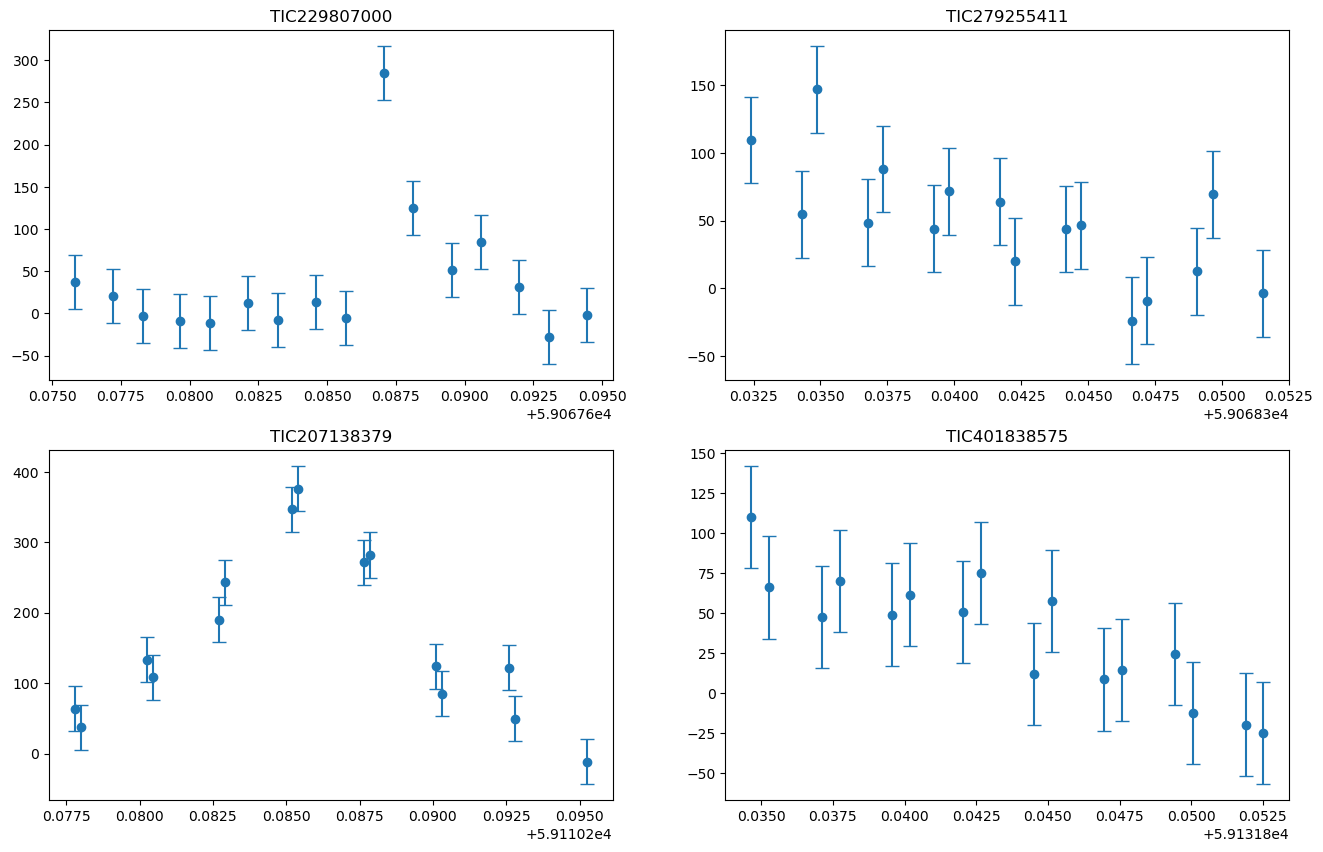

In [11]:
spt_flux = spt_flare_data['150_flux']
spt_flux_err = spt_flare_data['150_err']
spt_times = spt_flare_data['time']
fig = plt.figure(figsize= (16,10))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.2, hspace=0.2)

for i in range(len(spt_tess_candidates)):
    target = spt_tess_candidates.at[i, 'TIC']
    print(spt_tess_candidates.at[i, 'mjd'])
    ax = fig.add_subplot(gs[int(i/2), int(i%2)])
    # ax.scatter(time, flux)
    ax.errorbar(spt_times[lc_idxs[i]], spt_flux[lc_idxs[i]], yerr= 32*np.ones_like(np.abs(spt_flux_err[lc_idxs[i]])), fmt='o', capsize=5) #flux error currently hardcoded in as 32 mJy
    ax.set_title(target)


### Getting TESS data for flares

2 - TIC207138379
getting TPF from TESScut
made reference
made source mask
calculating background
background subtracted
aligning images
!!Re-running for difference image!!
shifting images
remade mask
background
background correlation correction
field calibration
target is below -30 dec, calibrating to SkyMapper photometry.


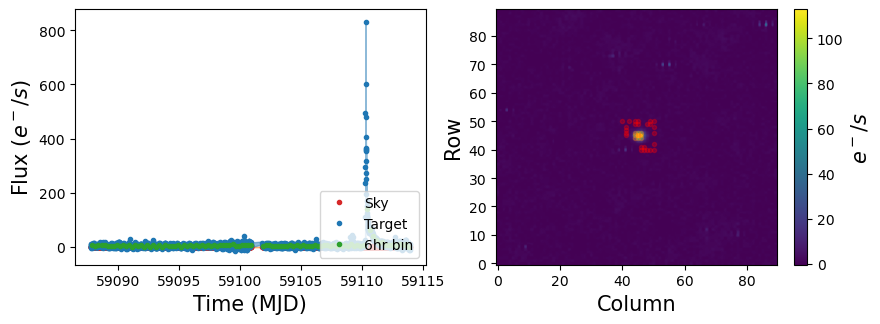

made reference
made source mask
calculating background
background subtracted
aligning images
!!Re-running for difference image!!
shifting images
!!!WARNING!!! mask is too dense, lowering mask_scale to 0.5, and raising maglim to 15. Background quality will be reduced.
remade mask
background
background correlation correction
field calibration
target is below -30 dec, calibrating to SkyMapper photometry.


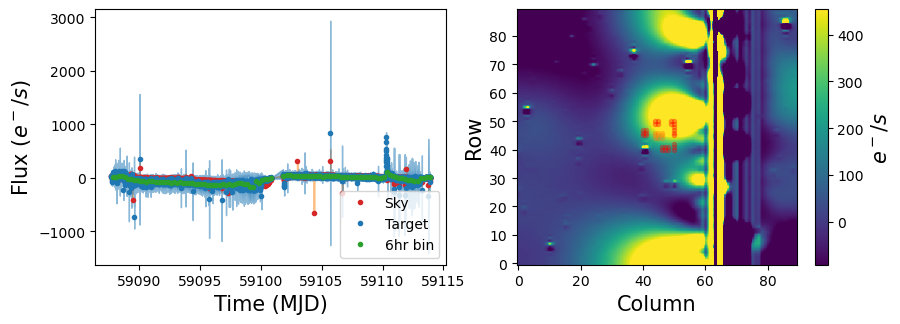

Pickling
Verifying Pickle
3 - TIC401838575
getting TPF from TESScut
made reference
made source mask
calculating background
background subtracted
aligning images
!!Re-running for difference image!!
shifting images
remade mask
background
background correlation correction
field calibration
target is below -30 dec, calibrating to SkyMapper photometry.


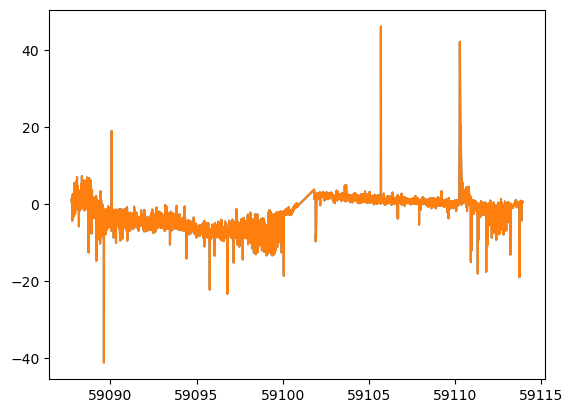

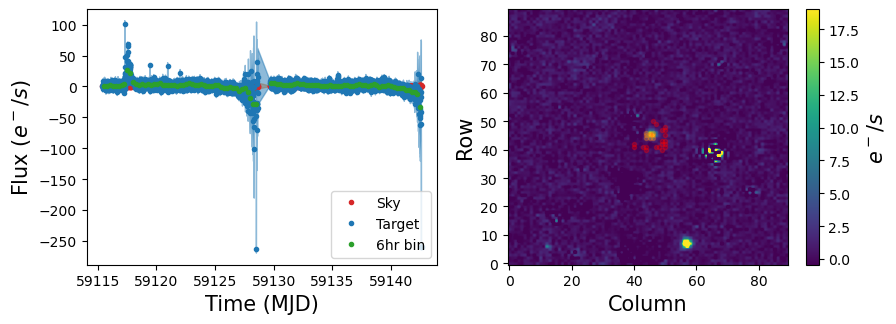

made reference
made source mask
calculating background
background subtracted
aligning images
!!Re-running for difference image!!
shifting images
!!!WARNING!!! mask is too dense, lowering mask_scale to 0.5, and raising maglim to 15. Background quality will be reduced.
remade mask
background
background correlation correction
field calibration
target is below -30 dec, calibrating to SkyMapper photometry.


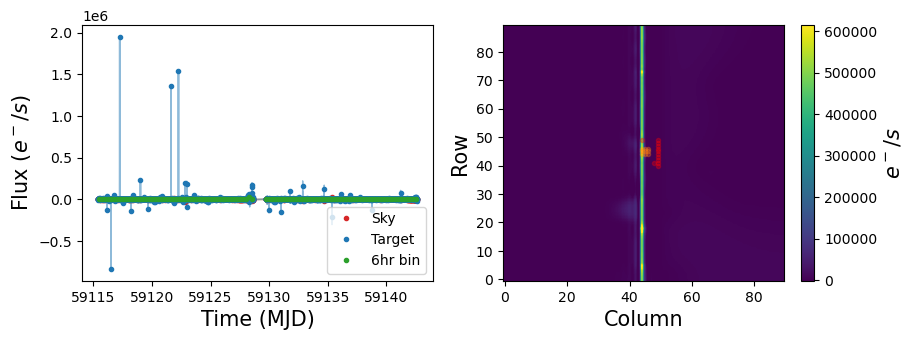

Pickling
Verifying Pickle


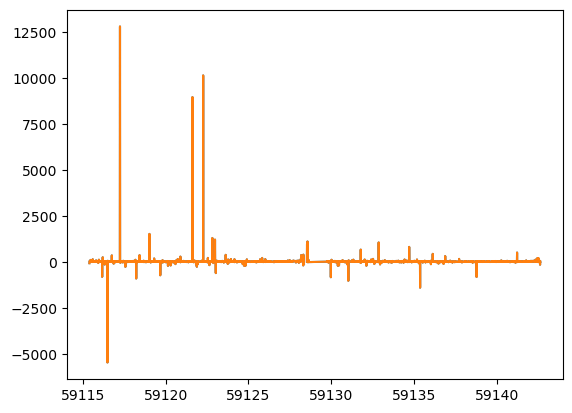

In [21]:
for i, flare in spt_tess_candidates.iterrows():
    if (i == 0 or i == 1): continue
    print(i, '-', flare['TIC'])
    ra = flare['ra']
    if ra < 0: ra += 360
    dec = flare['dec']
    sectors = flare['sectors']
    tess_obs = tr.tessreduce(ra= ra, dec= dec, sector = sectors[0])
    tess_obs.reduce()

    tess_obs.to_flux()
    lc = tess_obs.lc
    lc.shape
    plt.plot(lc[0], lc[1])

    print("Pickling")
    dbfile = open(f'{flare["TIC"]}_TR_LC', 'ab')
    pickle.dump(lc, dbfile)
    dbfile.close()

    print("Verifying Pickle")
    dbfile = open(f'{flare["TIC"]}_TR_LC', 'rb')
    lc = pickle.load(dbfile)
    dbfile.close()
    plt.plot(lc[0], lc[1])

## Some systems selected from Guns 2021:

7 - WISE J025531.87-570252.3 | TIC207138379 | SPT-SV J025532.4-570257

6 - CC ERI | TIC142206123

8 - UCAC3 53-724 | TIC425937691

In [ ]:
obj = lk.search_lightcurve('TIC207138379', mission= 'TESS', author= 'TESS-SPOC')
res_2020 = np.where(obj.table['year'] == 2020)

lightcurves = obj[res_2020].download_all()
lightcurves.plot()

obj[res_2020]

No data found for target "TIC279255411".


KeyError: 'year'

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='sap_flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

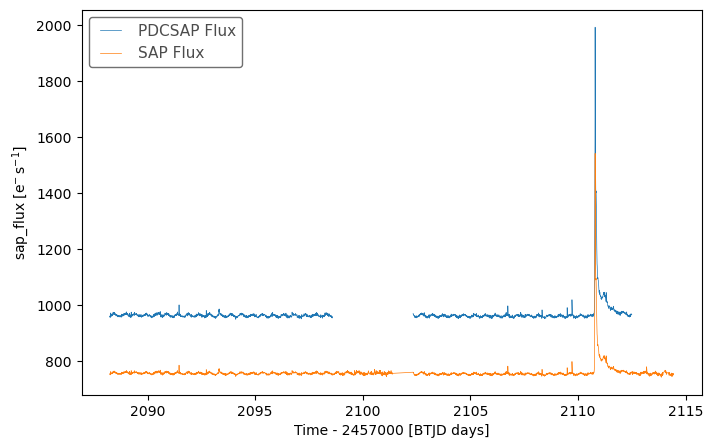

In [22]:
flare_obs = obj[res_2020][0].download()
fig_0 = plt.figure(figsize= (8,5))
ax1 = fig_0.add_subplot(1,1,1)
ax = flare_obs.plot(label= 'PDCSAP Flux', ax= ax1)
flare_obs.plot(column= 'sap_flux', label= 'SAP Flux', ax= ax1)
# ax1.set_xlim(2110,2114)

# Removing Quiescent Behaviors

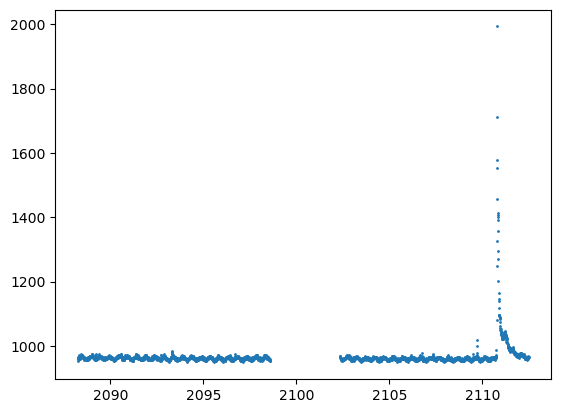

In [16]:
flare_obs_7 = ID7[res_2020_7][0].download()
qual = flare_obs_7.quality.value
time = np.array(flare_obs_7.time.value)
time = time[qual ==0]
sap_flux = np.array(flare_obs_7.pdcsap_flux.value)
sap_flux = sap_flux[qual ==0]
plt.scatter(time,sap_flux, s=1)

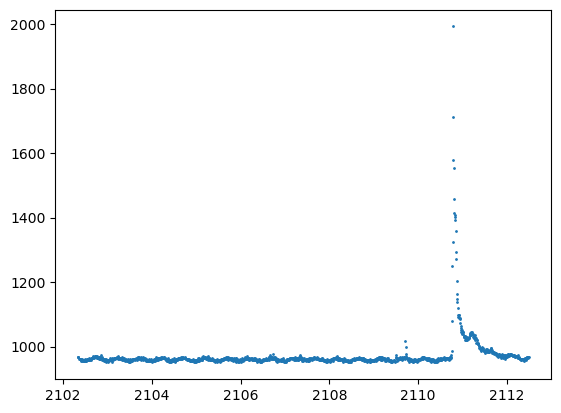

In [17]:
fitint_start = np.where(time>2102.)[0][0]
plt.scatter(time[fitint_start:],sap_flux[fitint_start:], s=1)
time = time[fitint_start:]
sap_flux = sap_flux[fitint_start:]

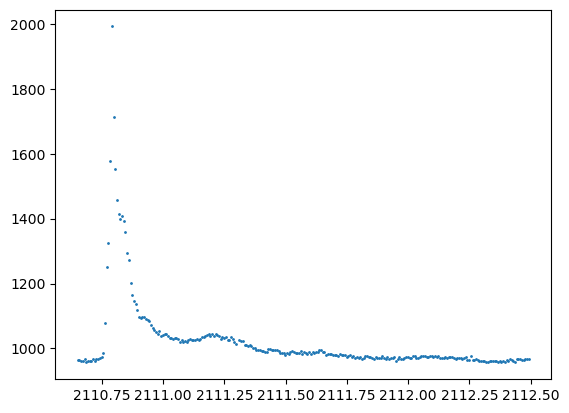

In [18]:
flare_start = np.where(time>2110.65)[0][0]
plt.scatter(time[flare_start:],sap_flux[flare_start:], s=1)

0.48727082229318813


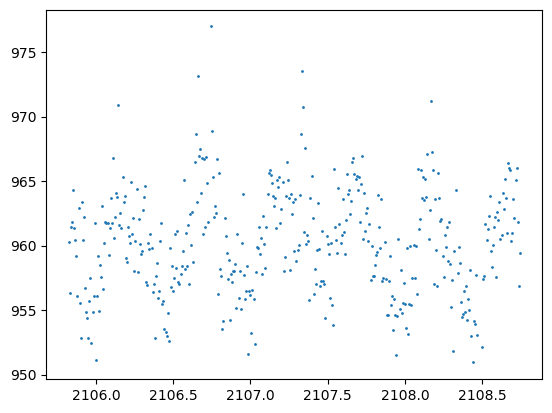

In [19]:
plt.scatter(time[500:915],sap_flux[500:915], s=1)
porb = (time[915]-time[500])/6
print(porb)

## numpy fft

In [20]:
def fit_with_numpyfft(time, flux, flare_start_idx):
    fit_time = time[:flare_start_idx]
    fit_flux = flux[:flare_start_idx]


    fft_coeffs = np.fft.fft(fit_flux)
    freq = np.fft.fftfreq(len(fit_time), d= (fit_time[1] - fit_time[0]))

    # # restrict terms to those above orbital frequency
    # valid_freq_ids = np.where(np.abs(freq) < 1/porb)[0]
    # print(np.min(1/np.abs(freq[valid_freq_ids])))
    # filtered_fft = np.zeros_like(fft_coeffs)
    # filtered_fft[valid_freq_ids] = fft_coeffs[valid_freq_ids]
    # print(len(freq), len(valid_freq_ids))

    model_flux = np.fft.ifft(fft_coeffs).real

    extrapolated_flux = np.zeros_like(time)
    for i,fr in enumerate(freq):#valid_freq_ids:
        amplitude = np.abs(fft_coeffs[i]) / len(fit_time)
        phase = np.angle(fft_coeffs[i])
        extrapolated_flux += amplitude * np.cos(2 * np.pi * fr * (time - time[0]) + phase)

    return model_flux, extrapolated_flux
    

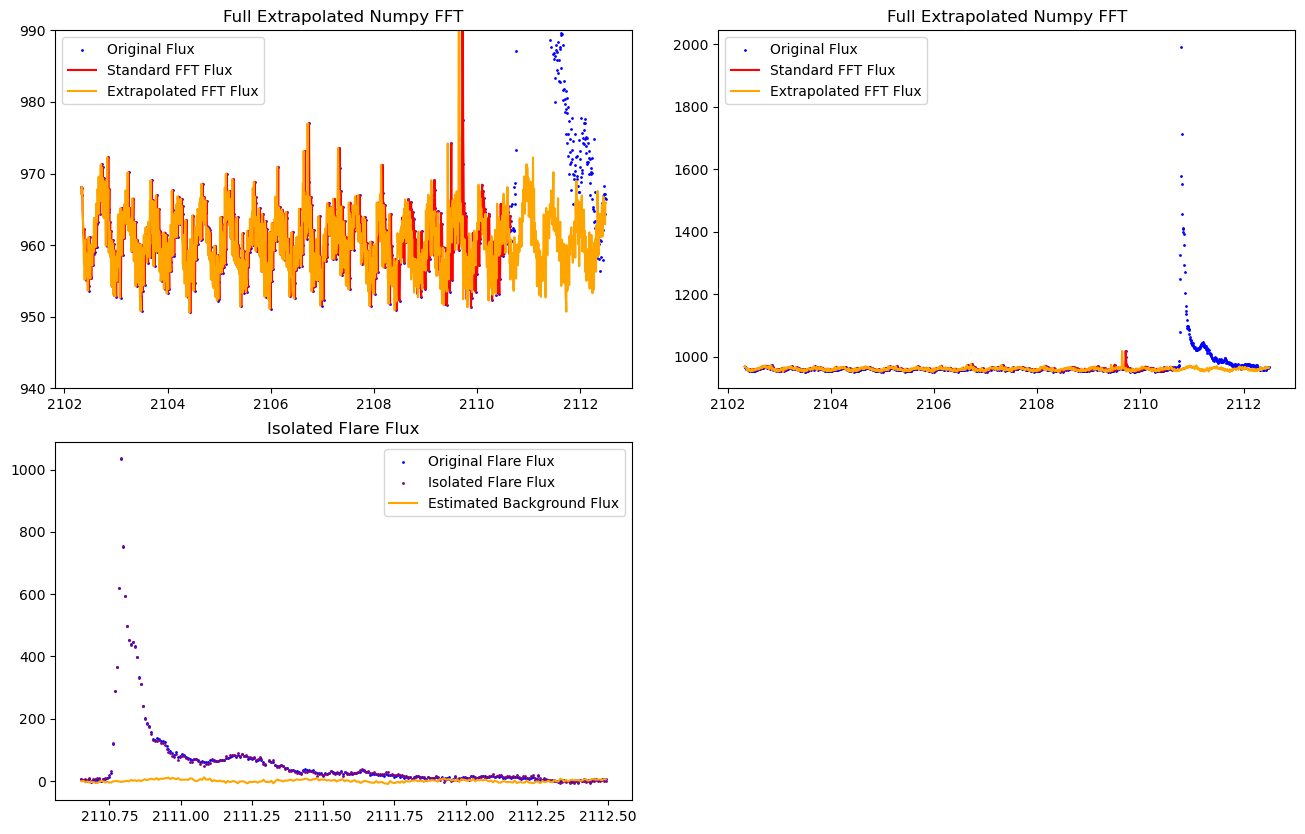

In [21]:
modulations, fitted_modulations = fit_with_numpyfft(time, sap_flux, flare_start)

fig = plt.figure(figsize= (16,10))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.15, hspace=0.15)

ax1 = fig.add_subplot(gs[0,0])
ax1.scatter(time, sap_flux, s= 1, c= 'b', label='Original Flux')
ax1.plot(time[:flare_start], modulations, c= 'r', label='Standard FFT Flux')
ax1.plot(time, fitted_modulations, c= 'orange', label='Extrapolated FFT Flux')
ax1.legend()
ax1.set_ylim(940,990)
ax1.set_title("Full Extrapolated Numpy FFT")

ax2 = fig.add_subplot(gs[0,1])
ax2.scatter(time, sap_flux, s= 1, c= 'b', label='Original Flux')
ax2.plot(time[:flare_start], modulations, c= 'r', label='Standard FFT Flux')
ax2.plot(time, fitted_modulations, c= 'orange', label='Extrapolated FFT Flux')
ax2.legend()
ax2.set_title("Full Extrapolated Numpy FFT")

ax3 = fig.add_subplot(gs[1,0])
ax3.scatter(time[flare_start:], sap_flux[flare_start:] - np.mean(sap_flux[:flare_start]), s= 1, c= 'b', label= "Original Flare Flux")
ax3.scatter(time[flare_start:], sap_flux[flare_start:] - fitted_modulations[flare_start:], s= 1, c= 'purple', label= "Isolated Flare Flux")
ax3.plot(time[flare_start:], fitted_modulations[flare_start:] - np.mean(sap_flux[:flare_start]), c= 'orange', label= "Estimated Background Flux")
ax3.legend()
ax3.set_title("Isolated Flare Flux")

plt.tight_layout()

## Fit Polynomial

In [ ]:
t = time[500:915] - np.mean(time[500:915])
flux = sap_flux[500:915]
flux_cut = np.where(flux < 974)
t = t[flux_cut]
flux = flux[flux_cut]

order = 12
def nth_order_poly(x, *coeffs):
    result = 0
    for i, c in enumerate(coeffs):
        result += c*x**i
    return result

initial_guess = np.zeros(order+1)
initial_guess[0] = 962.5

popt, pcov = curve_fit(lambda x, *params: nth_order_poly(x, *params), t, flux, p0= initial_guess)
print(popt)

y = lambda x: nth_order_poly(x, *popt)

plt.scatter(t, flux, s=1)
plt.plot(t, y(t))

## Cosine Transform Fit
Fails as cosine basis fit with finite terms will only fit well within fit duration, but we must extrapolate to approximate flux during flare.

In [ ]:
def cosine_transform_fit(time, flux, Porb):
    fit_time = time[:flare_start]
    fit_flux = flux[:flare_start]
    T = fit_time[-1] - fit_time[0]
    N = round((2 * T) / (Porb))
    print(N)

    def cosine_basis(t, i):
        return np.cos((2 * np.pi / (2 * T)) * i * t)
    # Create the design matrix using the cosine basis functions
    A = np.array([cosine_basis(fit_time, i) for i in range(0, N+1)]).T
    # Solve for the linear coefficients using least squares
    coeffs, _, _, _ = lstsq(A, fit_flux)
    # Calculate the model flux
    model_flux = np.dot(A, coeffs)

    A_full = np.array([cosine_basis(time, i) for i in range(0, N+1)]).T
    full_model_flux = np.dot(A_full, coeffs)

    return model_flux, full_model_flux

In [ ]:
modulations, fitted_modulations = cosine_transform_fit(time, sap_flux, porb)

# plt.plot(time[:flare_start], sap_flux[:flare_start], c= 'b', label='original flux')
# plt.plot(time[:flare_start], modulations, c= 'orange', label='modulation')
plt.plot(time, sap_flux, c= 'b', label='original flux')
plt.plot(time, fitted_modulations, c= 'orange', label='fitted flux')
plt.legend()

# Plotting to keep in back pocket

In [ ]:
modulations, fitted_modulations = fit_with_numpyfft(time, sap_flux, flare_start)

fig = plt.figure(figsize= (16,10))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.2, hspace=0.2)

ax1 = fig.add_subplot(gs[0,0])
ax1.scatter(time, sap_flux, s= 1, c= 'b', label='Original Flux')
ax1.plot(time[:flare_start], modulations, c= 'r', label='Standard FFT Flux')
ax1.plot(time, fitted_modulations, c= 'orange', label='Extrapolated FFT Flux')
ax1.legend()
ax1.set_ylim(940,990)
ax1.set_title("Full Extrapolated Numpy FFT")


gs_sub = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0, 1], wspace=0.4)
d = 0.5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax2_1 = fig.add_subplot(gs_sub[0,0])
ax2_1.scatter(time[:flare_start], sap_flux[:flare_start], s= 1, c= 'b', label='Original flux')
ax2_1.plot(time[:flare_start], modulations, c= 'r', label='Standard FFT')
ax2_1.plot(time[:flare_start], fitted_modulations[:flare_start], c= 'orange', label='Extrapolated FFT')
ax2_1.set_xlim(time[0], time[750])
ax2_1.spines.right.set_visible(False)
ax2_1.yaxis.tick_left()
ax2_1.plot([1, 1], [0, 1], transform=ax2_1.transAxes, **kwargs)

ax2_2 = fig.add_subplot(gs_sub[0,1])
ax2_2.plot(time[:flare_start], sap_flux[:flare_start], c= 'b', label='Original flux')
ax2_2.plot(time[:flare_start], modulations[:flare_start], c= 'r', label='Standard FFT')
ax2_2.plot(time[:flare_start], fitted_modulations[:flare_start], c= 'orange', label='Extrapolated FFT')
ax2_2.legend()
ax2_2.set_xlim(time[flare_start -750], time[flare_start])
ax2_2.spines.left.set_visible(False)
ax2_2.yaxis.tick_right()
ax2_2.tick_params(labelright= False)
ax2_2.plot([0, 0], [0, 1], transform=ax2_2.transAxes, **kwargs)

fig.text(0.73, 0.89, "Zoomed View of Fit Quality (Before Flare)", ha='center', fontsize=12)

ax3 = fig.add_subplot(2,2,3)
ax3.scatter(time[flare_start:], sap_flux[flare_start:] - np.mean(sap_flux[:flare_start]), s= 1, c= 'b', label= "Original Flare Flux")
ax3.scatter(time[flare_start:], sap_flux[flare_start:] - fitted_modulations[flare_start:], s= 1, c= 'purple', label= "Isolated Flare Flux")
ax3.plot(time[flare_start:], fitted_modulations[flare_start:] - np.mean(sap_flux[:flare_start]), c= 'orange', label= "Estimated Background Flux")
ax3.legend()
ax3.set_title("Isolated Flare Flux")


ax4 = fig.add_subplot(2,2,4)
ax4.scatter(time[:flare_start], fitted_modulations[:flare_start] - modulations, s= 1, c= 'orange', label= 'Extrapolation Error')
ax4.legend()
ax4.set_title("Residuals (before flare)")

plt.tight_layout()